In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join as join_path

import torch
import numpy as np
from matplotlib import pyplot as plt

from albo.test_functions.synthetic import GramacyTestFunction
from albo.test_functions.plotting import get_feasibility_plot_2d

In [3]:
def get_traces(dump_dir):
    traces = list()
    for f in os.scandir(dump_dir):
        if f.is_dir() :
            try:
                trace_file = join_path(f.path, 'trace.npy')
                trace = np.load(trace_file, allow_pickle=True)
                traces.append(trace)
            except:
                pass
    return traces

In [4]:
test_fcn = GramacyTestFunction()

Found 79 runs


/home/stys/anaconda3/envs/albo/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in subtract


Text(0.5, 1.0, 'Utility')

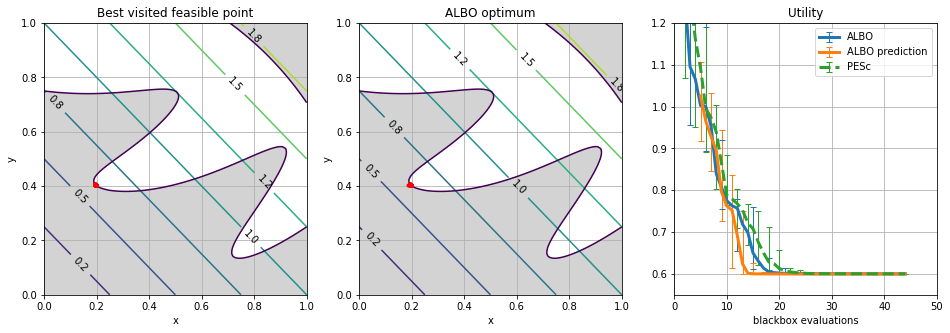

In [7]:
traces = get_traces('/home/stys/work/dumps/albo/gramacy_classic/noiseless_r10_mc500_albest/noiseless_r10_mc500/')
nruns = len(traces)
print('Found %d runs' % nruns)
fh = plt.figure(figsize=(16, 5))
ax1, ax2, ax3 = fh.subplots(1, 3)

best_points = np.zeros((nruns, test_fcn.dim))    
for i in range(nruns):
    trace = traces[i].tolist()
    idx_best = trace['idx_best']
    idx_best_final = trace['idx_best'][-1]
    x_train = trace['x'].numpy()
    x_best = x_train[idx_best_final]
    best_points[i, :] = x_best
contours = get_feasibility_plot_2d(ax1, test_fcn)
ax1.scatter(best_points[:, 0], best_points[:, 1], c='r', marker='.', zorder=10)
ax1.grid()
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1])
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Best visited feasible point')

final_points = np.zeros((nruns, test_fcn.dim))
for i in range(nruns):
    trace = traces[i].tolist()
    x_pred = trace['x_al'].numpy()
    final_points[i, :] = x_pred[-1]
contours = get_feasibility_plot_2d(ax2, test_fcn)
ax2.scatter(final_points[:, 0], final_points[:, 1], c='r', marker='.', zorder=50)   
ax2.grid()
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('ALBO optimum')

n = traces[0].tolist()['y'].shape[0]
y_best = np.zeros((nruns, n))
for i in range(nruns):
    trace = traces[i].tolist()
    idx_best = trace['idx_best']
    y = trace['y'][:, 0]
    valid = (idx_best >= 0)
    y_best[i, :] = np.where(valid, y[idx_best], np.inf)
y_best_median = np.median(y_best, 0)
every_3 = np.array(list(x % 3 == 0 for x in range(len(valid))))
y_best_q75 = np.where(every_3, np.quantile(y_best, 0.75, 0), 0)
y_best_q25 = np.where(every_3, np.quantile(y_best, 0.25, 0), 0)
ax3.errorbar(
    range(n),
    y_best_median,
    np.array([y_best_median - y_best_q25, y_best_q75 - y_best_median]),
    linewidth=3,
    elinewidth=1,
    capsize=3,
    label='ALBO'
)
ax3.grid()
ax3.set_xlim([0, 50])
ax3.set_ylim([0.55, 1.2])

L = np.zeros((nruns, n))
for i in range(nruns):
    for j, t in enumerate(traces[i].tolist()['traces_inner']):
        if j < n:
            if t is not None:
                L[i, j] = - t[-1]['L']
            else:
                L[i, j] = np.nan
L_median = np.median(L, axis=0)
every_3_1 = np.array(list((x+1) % 2 == 0 for x in range(len(valid))))
L_q75 = np.where(every_3_1, np.quantile(L, 0.75, 0), 0)
L_q25 = np.where(every_3_1, np.quantile(L, 0.25, 0), 0)
ax3.errorbar(
    range(n),
    L_median,
    np.array([L_median - L_q25, L_q75 - L_median]),
    linewidth=3,
    elinewidth=1,
    capsize=3,
    label='ALBO prediction'
)

pesc_results = np.load('/home/stys/work/contrib/Spearmint/examples/toy2/best_f.npy')
pesc_median = np.nanmedian(pesc_results, axis=0)[:n]
every_3_2 = np.array(list((x+2) % 2 == 0 for x in range(len(valid))))
pesc_q75 = np.where(every_3_2, np.nanquantile(pesc_results, q=0.75, axis=0)[:n], 0)
pesc_q25 = np.where(every_3_2, np.nanquantile(pesc_results, q=0.25, axis=0)[:n], 0)

ax3.errorbar(
    range(n),
    pesc_median,
    np.array([pesc_median - pesc_q25, pesc_q75 - pesc_median]),
    linewidth=3,
    elinewidth=1,
    capsize=3,
    linestyle='--',
    label='PESc'
)

ax3.legend()
ax3.set_xlabel('blackbox evaluations')
ax3.set_title('Utility')

In [42]:
test_fcn(torch.Tensor([[0.195047, 0.404853]]))

tensor([[ 5.9990e-01, -1.2860e-04, -1.2981e+00]])